In [34]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
items = pd.read_csv("data/items.csv")
items_categories = pd.read_csv("data/item_categories.csv")
sales_train = pd.read_csv("data/sales_train.csv")
shops = pd.read_csv("data/shops.csv")

df_init = pd.merge(items, items_categories, on="item_category_id", how="inner")
df_init = pd.merge(df_init, sales_train, on="item_id", how="inner")
df_init.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


## DELETE OUTLIERS

In [11]:
df_init["item_cnt_day"].value_counts()

 1.0     2629372
 2.0      194201
 3.0       47350
 4.0       19685
 5.0       10474
-1.0        7252
-2.0          78
-3.0          14
-5.0           4
-4.0           3
-6.0           2
-22.0          1
-16.0          1
-9.0           1
Name: item_cnt_day, dtype: int64

### Take 99th percentile of sells in a day

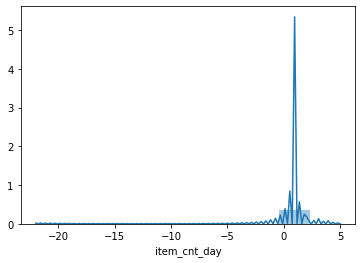

In [12]:
g = sns.distplot(a = df_init["item_cnt_day"], bins=10)

In [13]:
print(len(df_init))
df_init = df_init[df_init["item_cnt_day"] <= np.percentile(a=df_init["item_cnt_day"], q=99)]
print(len(df_init))
df_init.head()

2908438
2897964


,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


### Delete negative item_cnt_day -> Devolutions

In [14]:
(df_init["item_cnt_day"] < 0).sum()

7356

In [15]:
print(len(df_init))
df_init = df_init[df_init["item_cnt_day"] > 0]
print(len(df_init))
df_init.head()

2897964
2890608


,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


## DEFINE FEATURES PARAMETERS

In [45]:
month_to_predict = 34
max_train_month = 33
features_folder_name = "features_prediction/"

In [9]:
df = df_init[df_init["date_block_num"] < month_to_predict]
assert(df["date_block_num"].max() == max_train_month)
print("Maximum month in features after processing will be:", df.date_block_num.value_counts().index.max())
df.head()

Maximum month in features after processing will be: 33


,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


## FEATURES

### Of categories and shops (shop_id & item_category_id)

#### Items sold from the same categorie in the same shop last month

In [10]:
items_same_cat_and_shop = df[df.date_block_num == max_train_month].groupby(["shop_id", "item_category_id"]).agg({"item_cnt_day":"sum"}).reset_index().rename(columns={"item_cnt_day":"sold_cat_last_month_by_shop"})
items_same_cat_and_shop.head()

categories_and_shops = items_same_cat_and_shop
print(len(categories_and_shops))

print(categories_and_shops["sold_cat_last_month_by_shop"].isna().sum())
categories_and_shops.sample(10)

1757
0


,shop_id,item_category_id,sold_cat_last_month_by_shop
1311,46,56,6.0
718,25,61,131.0
187,6,69,19.0
1271,45,56,3.0
70,3,71,18.0
1561,53,49,2.0
6,2,19,70.0
975,36,63,15.0
314,12,42,41.0
1048,38,38,12.0


#### Items sold from the same categorie in the same shop historically by month (mean, sum, std, min, max)

In [11]:
items_same_cat_and_shop = df.groupby(["shop_id", "item_category_id", "date_block_num"]).agg({"item_cnt_day":"sum"}).reset_index()

In [12]:
items_same_cat_and_shop.head()

,shop_id,item_category_id,date_block_num,item_cnt_day
0,0,0,1,1.0
1,0,1,1,1.0
2,0,2,0,53.0
3,0,2,1,52.0
4,0,3,0,28.0


In [13]:
items_same_cat_and_shop_h = items_same_cat_and_shop.groupby(["shop_id", "item_category_id"]).agg({"item_cnt_day":["sum", "mean", "std", "min", "max"]}).reset_index()

items_same_cat_and_shop_h.columns = ['_'.join(col).strip() for col in items_same_cat_and_shop_h.columns.values]

items_same_cat_and_shop_h.rename(columns={
   "shop_id_":"shop_id",
    "item_category_id_":"item_category_id",
    "item_cnt_day_sum":"hist_sales_sum_cat_by_shop",
    "item_cnt_day_mean":"hist_sales_mean_cat_by_shop",
    "item_cnt_day_std":"hist_sales_std_cat_by_shop",
    "item_cnt_day_min":"hist_sales_min_cat_by_shop",
    "item_cnt_day_max":"hist_sales_max_cat_by_shop"
}, inplace=True)

print(len(categories_and_shops))
print(len(items_same_cat_and_shop_h))
categories_and_shops = pd.merge(items_same_cat_and_shop_h, categories_and_shops, on=["shop_id", "item_category_id"], how="left")
print(len(categories_and_shops))
categories_and_shops.head()

1757
3271
3271


,shop_id,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop
0,0,0,1.0,1.0,NaN,1.0,1.0,NaN
1,0,1,1.0,1.0,NaN,1.0,1.0,NaN
2,0,2,105.0,52.5,0.707107,52.0,53.0,NaN
3,0,3,52.0,26.0,2.828427,24.0,28.0,NaN
4,0,4,38.0,19.0,4.242641,16.0,22.0,NaN


In [14]:
categories_and_shops.to_csv("generated/" + features_folder_name + "features_shop_and_categories.csv", index=False)

### Of categories (category_id)

#### Total shops that sell items with that category

In [15]:
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


In [16]:
categories_features = df.groupby("item_category_id").agg({"shop_id":"nunique"}).reset_index().rename(columns={"shop_id":"total_shops_of_category"})
print(len(items_categories))
print(len(categories_features))
categories_features.sample(10)

84
84


,item_category_id,total_shops_of_category
74,74,1
63,63,59
35,35,58
72,72,59
59,59,48
38,38,58
25,25,55
80,80,37
73,73,55
27,27,1


#### Total items by category

In [17]:
items_by_category = df.groupby("item_category_id").agg({"item_id":"nunique"}).reset_index().rename(columns={"item_id":"total_items_of_category"})
items_by_category.sample(7)

,item_category_id,total_items_of_category
11,11,40
29,29,43
71,71,6
31,31,1098
64,64,280
62,62,293
4,4,15


In [18]:
print(len(categories_features))
categories_features = pd.merge(categories_features, items_by_category, on="item_category_id", how="inner")
print(len(categories_features))
categories_features.sample(7)

84
84


,item_category_id,total_shops_of_category,total_items_of_category
75,75,57,272
23,23,58,496
79,79,51,1
58,58,55,769
59,59,48,294
0,0,3,3
73,73,55,36


#### Historical mean sales of category by month

In [19]:
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


In [20]:
sum_sales_of_category = df.groupby(["item_category_id", "date_block_num"]).agg({"item_cnt_day":"sum"}).reset_index()
mean_sales_of_category = df.groupby("item_category_id").agg({"item_cnt_day":"mean"}).reset_index().rename(columns={"item_cnt_day":"mean_sales_of_category_by_month"})
categories_features = pd.merge(categories_features, mean_sales_of_category)
categories_features.sample(10)

,item_category_id,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month
17,17,44,7,1.003247
66,66,23,178,1.187928
47,47,45,129,1.104878
59,59,48,294,1.004239
26,26,1,3,1.200000
75,75,57,272,1.126768
74,74,1,8,1.053571
38,38,58,310,1.057784
1,1,2,2,1.000000
25,25,55,128,1.048082


In [21]:
categories_features.to_csv("generated/" + features_folder_name + "features_categories.csv", index=False)

### Of shops (shop_id)

#### Total categories by shop

In [22]:
t_cat_by_shop = df.groupby("shop_id").agg({"item_category_id":"nunique"}).reset_index().rename(columns={"item_category_id":"tot_cat_by_shops"})
t_cat_by_shop.head()

print(len(shops))
shops_features = t_cat_by_shop
print(len(shops_features))
shops_features.sample(10)

60
60


,shop_id,tot_cat_by_shops
10,10,57
32,32,47
1,1,41
17,17,55
54,54,59
51,51,56
18,18,62
8,8,43
16,16,63
3,3,58


#### Number of items sold by shop in the last month

In [23]:
items_sold_last_month = df[df["date_block_num"] == max_train_month].groupby("shop_id").agg({"item_cnt_day":"sum"}).reset_index().rename(columns={"item_cnt_day":"items_sold_last_month"})

shops_features = pd.merge(shops_features, items_sold_last_month, on="shop_id", how="left")
print(shops_features["items_sold_last_month"].isna().sum())
shops_features["items_sold_last_month"] = shops_features["items_sold_last_month"].fillna(0) 
print(len(shops_features))
shops_features.sample(5)

16
60


,shop_id,tot_cat_by_shops,items_sold_last_month
32,32,47,0.0
55,55,12,1795.0
14,14,60,956.0
6,6,63,1679.0
26,26,61,1265.0


#### Number of items sold by shop in last n months

In [24]:
months = [max_train_month - 1 - i for i in range(5)]
months

[32, 31, 30, 29, 28]

In [25]:
print(len(shops_features))
for month in months:
    items_sold_in_month = df[df["date_block_num"] == month].groupby("shop_id").agg({"item_cnt_day":"sum"}).reset_index().\
    rename(columns={"item_cnt_day":"items_sold_by_shop_last_" + str(month_to_predict - month) + "_months"})
    shops_features = pd.merge(shops_features, items_sold_in_month, on="shop_id", how="left")
    print(len(shops_features))
shops_features.sample(10)

60
60
60
60
60
60


,shop_id,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months
37,37,63,754.0,948.0,1179.0,1036.0,797.0,821.0
10,10,57,428.0,488.0,442.0,429.0,431.0,394.0
17,17,55,0.0,NaN,NaN,NaN,NaN,NaN
36,36,35,333.0,NaN,NaN,NaN,NaN,NaN
56,56,63,1241.0,1160.0,1540.0,1486.0,1508.0,1277.0
30,30,59,0.0,NaN,NaN,NaN,NaN,NaN
53,53,60,1010.0,1195.0,1296.0,1255.0,1067.0,1097.0
14,14,60,956.0,990.0,1051.0,939.0,887.0,743.0
54,54,59,0.0,NaN,NaN,NaN,NaN,NaN
27,27,60,0.0,NaN,NaN,2316.0,3181.0,3297.0


In [26]:
shops_features.to_csv("generated/" + features_folder_name +"features_shops.csv", index=False)

### By item in specific shop (item_id & shop_id)

#### Items sold in shop last month

In [27]:
item_purchases_by_shop_last_month = df[df["date_block_num"] == max_train_month].groupby(["shop_id", "item_id"]).agg({"item_cnt_day":"sum"}).reset_index().rename(columns={"item_cnt_day":"purchases_item_in_shop_last_month"})

features_items_and_shops = item_purchases_by_shop_last_month

features_items_and_shops.sample(10)

,shop_id,item_id,purchases_item_in_shop_last_month
3065,7,5004,1.0
31411,59,16898,1.0
23833,46,18047,1.0
5272,14,15217,1.0
11446,25,7724,4.0
3116,7,6285,1.0
11271,25,5654,1.0
31078,59,3652,1.0
221,2,8737,1.0
6973,18,7789,1.0


#### Item sold in shop in different months

In [28]:
months = [max_train_month - 1 - i for i in range(5)]
months

[32, 31, 30, 29, 28]

In [29]:
for month in months:
    print(len(features_items_and_shops))
    item_purchases_by_shop_in_month = df[df["date_block_num"] == month].groupby(["shop_id", "item_id"]).agg({"item_cnt_day":"sum"}).reset_index().rename(columns={"item_cnt_day":"purchases_item_in_shop_month_" + str(month_to_predict - month)})
    features_items_and_shops = pd.merge(features_items_and_shops, item_purchases_by_shop_in_month, on=["shop_id", "item_id"], how="outer")
    print(len(features_items_and_shops))

31491
49401
49401
65027
65027
78594
78594
88586
88586
97933


In [30]:
features_items_and_shops.head()

,shop_id,item_id,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6
0,2,31,1.0,NaN,NaN,NaN,NaN,NaN
1,2,486,3.0,1.0,NaN,NaN,2.0,NaN
2,2,787,1.0,NaN,NaN,NaN,NaN,NaN
3,2,794,1.0,NaN,NaN,NaN,NaN,NaN
4,2,968,1.0,NaN,NaN,NaN,NaN,NaN


#### Historical sales for shop in specific item (sum, mean, std, min, max)

In [31]:
sales_of_item_in_shop_by_month = df.groupby(["item_id", "shop_id", "date_block_num"]).agg({"item_cnt_day":"sum"}).reset_index()
# careful: only considering months that have al least one purchase.
sales_of_item_in_shop_by_month_h = sales_of_item_in_shop_by_month.groupby(["item_id", "shop_id"]).agg({"item_cnt_day": ["mean", "sum", "std", "max", "min"]}).reset_index().rename(columns={"sales_in_month":"average_sales_for_item_and_shop_by_month"})

sales_of_item_in_shop_by_month_h.columns = ['_'.join(col).strip() for col in sales_of_item_in_shop_by_month_h.columns.values]

sales_of_item_in_shop_by_month_h.rename(columns={
   "shop_id_":"shop_id",
    "item_id_":"item_id",
    "item_cnt_day_sum":"hist_sales_sum_item_by_shop",
    "item_cnt_day_mean":"hist_sales_mean_item_by_shop",
    "item_cnt_day_std":"hist_sales_std_item_by_shop",
    "item_cnt_day_min":"hist_sales_min_item_by_shop",
    "item_cnt_day_max":"hist_sales_max_item_by_shop"
}, inplace=True)

print(len(features_items_and_shops))
print(len(sales_of_item_in_shop_by_month_h))
features_items_and_shops = pd.merge(sales_of_item_in_shop_by_month_h, features_items_and_shops, on=["shop_id", "item_id"],how="left")
print(len(features_items_and_shops))

features_items_and_shops.sample(10)

97933
424008
424008


,item_id,shop_id,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6
296681,15656,31,1.500000,3.0,0.707107,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
210483,11549,26,2.500000,5.0,2.121320,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
183160,10296,18,1.000000,3.0,0.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
80139,4802,16,2.000000,4.0,1.414214,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
53807,3412,55,1.666667,5.0,0.577350,2.0,1.0,NaN,NaN,1.0,2.0,2.0,NaN
136620,7860,35,2.722222,49.0,1.934381,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
11932,1241,39,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
207913,11428,51,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
235608,12785,59,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
69762,4266,52,1.428571,10.0,0.786796,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Last ten months sales for shop in specific item (sum, mean, std, min, max) 

In [32]:
sales_of_item_in_shop_by_month_10 = df[df.date_block_num >= max_train_month - 10].groupby(["item_id", "shop_id", "date_block_num"]).agg({"item_cnt_day":"sum"}).reset_index()
# careful: only considering months that have al least one purchase.
sales_of_item_in_shop_by_month_h_10 = sales_of_item_in_shop_by_month_10.groupby(["item_id", "shop_id"]).agg({"item_cnt_day": ["mean", "sum", "std", "max", "min"]}).reset_index().rename(columns={"sales_in_month":"average_sales_for_item_and_shop_by_month"})

sales_of_item_in_shop_by_month_h_10.columns = ['_'.join(col).strip() for col in sales_of_item_in_shop_by_month_h_10.columns.values]

sales_of_item_in_shop_by_month_h_10.rename(columns={
   "shop_id_":"shop_id",
    "item_id_":"item_id",
    "item_cnt_day_sum":"ten_month_sales_sum_item_by_shop",
    "item_cnt_day_mean":"ten_month_mean_item_by_shop",
    "item_cnt_day_std":"ten_month_std_item_by_shop",
    "item_cnt_day_min":"ten_month_min_item_by_shop",
    "item_cnt_day_max":"ten_month_max_item_by_shop"
}, inplace=True)

print(len(features_items_and_shops))
print(len(sales_of_item_in_shop_by_month_h_10))
features_items_and_shops = pd.merge(sales_of_item_in_shop_by_month_h_10, features_items_and_shops, on=["shop_id", "item_id"],how="left")
print(len(features_items_and_shops))

features_items_and_shops.sample(10)

424008
158595
158595


,item_id,shop_id,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6
70673,10299,45,1.000000,1.0,NaN,1.0,1.0,1.000000,4.0,0.000000,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN
55962,7924,42,1.500000,6.0,1.000000,3.0,1.0,1.428571,10.0,0.786796,3.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
23357,3556,25,2.900000,29.0,1.791957,7.0,1.0,3.888889,105.0,2.516611,10.0,1.0,NaN,2.0,3.0,2.0,2.0,2.0
61939,8737,45,2.000000,4.0,1.414214,3.0,1.0,2.000000,4.0,1.414214,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN
144377,20048,19,1.000000,4.0,0.000000,1.0,1.0,1.000000,5.0,0.000000,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0
44397,6185,12,1.333333,4.0,0.577350,2.0,1.0,1.333333,12.0,0.500000,2.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN
55038,7842,28,4.200000,21.0,3.768289,10.0,1.0,4.200000,21.0,3.768289,10.0,1.0,2.0,NaN,2.0,1.0,10.0,6.0
152671,21384,51,1.000000,1.0,NaN,1.0,1.0,3.714286,26.0,3.450328,9.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
97914,13859,58,1.000000,1.0,NaN,1.0,1.0,2.000000,12.0,1.264911,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
13211,2484,34,1.000000,1.0,NaN,1.0,1.0,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN


#### Time since last and first purchase of item in shop

In [33]:
with_last_purchase_month = df.groupby(["item_id", "shop_id"]).agg({"date_block_num":"max"}).reset_index().rename(columns={"date_block_num":"month_last_purchase_of_item_in_shop"})
with_first_purchase_month = df.groupby(["item_id", "shop_id"]).agg({"date_block_num":"min"}).reset_index().rename(columns={"date_block_num":"month_first_purchase_of_item_in_shop"})

print(len(features_items_and_shops))
features_items_and_shops = pd.merge(features_items_and_shops, with_last_purchase_month, on=["shop_id", "item_id"], how="inner")
features_items_and_shops = pd.merge(features_items_and_shops, with_first_purchase_month, on=["shop_id", "item_id"], how="inner")
print(len(features_items_and_shops))
features_items_and_shops.sample(10)

158595
158595


,item_id,shop_id,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop
152854,21389,42,2.0,6.0,1.0,3.0,1.0,3.500000,14.0,3.109126,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,26,22
32155,4579,7,1.0,1.0,NaN,1.0,1.0,1.000000,3.0,0.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,26,6
51658,7235,14,1.0,1.0,NaN,1.0,1.0,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,29,29
49363,6911,25,1.0,1.0,NaN,1.0,1.0,2.142857,30.0,1.406422,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,23,0
82207,11892,46,1.0,1.0,NaN,1.0,1.0,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,31,31
63674,9047,15,1.0,1.0,NaN,1.0,1.0,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,31,31
8219,1783,7,1.0,1.0,NaN,1.0,1.0,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,26,26
38979,5572,51,1.0,2.0,0.0,1.0,1.0,1.615385,21.0,0.650444,3.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,30,0
62979,8893,21,1.0,1.0,NaN,1.0,1.0,1.000000,3.0,0.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,23,4
52835,7487,18,1.0,6.0,0.0,1.0,1.0,1.000000,6.0,0.000000,1.0,1.0,NaN,NaN,NaN,1.0,NaN,1.0,30,24


#### Number of months in there was a sell of item in shop

In [34]:
total_months_with_sells = df.groupby(["item_id", "shop_id"]).agg({"date_block_num":"nunique"}).reset_index().rename(columns={"date_block_num":"total_months_with_sells_by_item_and_shop"})
total_months_with_sells.sample(7)

,item_id,shop_id,total_months_with_sells_by_item_and_shop
120422,6930,56,2
33969,2439,45,7
251832,13624,45,1
323135,16946,10,1
39467,2743,34,6
231663,12607,4,2
302687,15989,25,7


In [35]:
print(len(features_items_and_shops))
features_items_and_shops = pd.merge(features_items_and_shops, total_months_with_sells, on=["item_id", "shop_id"], how="inner")
print(len(features_items_and_shops))
features_items_and_shops.sample(7)

158595
158595


,item_id,shop_id,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,...,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop
39568,5638,51,1.000000,1.0,NaN,1.0,1.0,1.000000,1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,23,23,1
30830,4421,57,1.000000,1.0,NaN,1.0,1.0,1.166667,14.0,0.389249,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,23,2,12
17768,2946,29,1.333333,4.0,0.57735,2.0,1.0,1.400000,14.0,0.516398,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,28,1,10
121435,16461,30,1.000000,1.0,NaN,1.0,1.0,1.200000,6.0,0.447214,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,23,8,5
70380,10225,54,2.000000,2.0,NaN,2.0,2.0,1.230769,16.0,0.438529,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,25,2,13
91498,13216,28,1.000000,2.0,0.00000,1.0,1.0,1.000000,2.0,0.000000,...,1.0,1.0,NaN,1.0,NaN,NaN,NaN,33,31,2
21451,3385,3,1.000000,1.0,NaN,1.0,1.0,1.250000,5.0,0.500000,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,31,16,4


In [36]:
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


In [37]:
features_items_and_shops.to_csv("generated/" + features_folder_name + "features_items_and_shop.csv", index=False)

### Of items (item_id)

#### Max, mean, std, and min item price

In [38]:
with_price_features = df.groupby("item_id").agg({"item_price":["max", "mean", "min", "std"]}).reset_index()
with_price_features.columns = ['_'.join(col).strip() for col in with_price_features.columns.values]
with_price_features["diff_price_max_min"] = with_price_features["item_price_max"] - with_price_features["item_price_min"]
with_price_features.rename(columns={"item_id_":"item_id"}, inplace=True)

items_features = with_price_features

items_features.sample(7)

,item_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min
13352,13612,600.0,596.363158,348.0,25.75286,252.0
1778,1819,1499.0,1499.000000,1499.0,0.00000,0.0
5608,5715,1280.0,1280.000000,1280.0,0.00000,0.0
5453,5558,2000.0,2000.000000,2000.0,NaN,0.0
774,792,979.0,970.585567,405.0,65.24217,574.0
18043,18354,148.0,110.500000,98.0,25.00000,50.0
17369,17675,399.0,399.000000,399.0,0.00000,0.0


#### Total shops that sell specific item

In [39]:
with_different_shops = df.groupby("item_id").agg({"shop_id":"nunique"}).reset_index().rename(columns={"shop_id":"total_shops_item_is_sell"})

print(len(items_features))
items_features = pd.merge(items_features, with_different_shops, on="item_id", how="inner")
print(len(items_features))

items_features.sample(10)

21798
21798


,item_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell
7246,7397,299.0,296.726562,202.0,14.732638,97.0,44
7222,7373,249.0,249.000000,249.0,0.000000,0.0,18
2737,2796,1299.0,1095.004762,298.0,248.777847,1001.0,31
11580,11792,399.0,399.000000,399.0,0.000000,0.0,3
20284,20627,649.0,643.982182,375.0,36.941681,274.0,35
19179,19501,1199.0,956.142857,799.0,178.516475,400.0,4
11010,11217,499.0,460.590580,190.0,81.502381,309.0,38
2013,2058,198.0,120.166667,29.0,66.052757,169.0,5
7417,7568,549.0,462.857143,248.0,118.503767,301.0,7
98,99,149.0,130.798594,70.0,24.724435,79.0,31


#### Mean sales of item historically by month

In [40]:
items_sells_historically = df.groupby(["item_id", "date_block_num"]).agg({"item_cnt_day":"sum"}).reset_index()
mean_items_sells = items_sells_historically.groupby("item_id").agg({"item_cnt_day":"mean"}).reset_index().rename(columns={"item_cnt_day":"sales_item_historically_mean"})
items_features = pd.merge(items_features, mean_items_sells, on="item_id", how="inner")
items_features.sample(10)

,item_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean
5010,5106,499.0,499.000000,499.00,0.000000,0.00,8,8.833333
19334,19657,749.0,738.866667,711.00,12.780158,38.00,17,45.000000
6530,6667,698.0,698.000000,698.00,NaN,0.00,1,1.000000
6748,6895,299.0,212.681481,46.40,65.118478,252.60,15,1.928571
6687,6832,1249.0,1249.000000,1249.00,0.000000,0.00,3,1.000000
13044,13289,649.0,649.000000,649.00,0.000000,0.00,2,2.000000
5766,5879,3290.0,3290.000000,3290.00,0.000000,0.00,3,1.500000
7165,7316,299.0,290.181818,202.00,28.541759,97.00,16,4.400000
6285,6405,299.0,275.157150,155.13,38.594695,143.87,23,5.676471
9482,9675,199.0,195.960000,123.00,15.200000,76.00,16,2.272727


#### Mean of item sales last ten months

In [41]:
items_sells_historically_10 = df[df.date_block_num >= max_train_month - 10].groupby(["item_id", "date_block_num"]).agg({"item_cnt_day":"sum"}).reset_index()
mean_items_sells_10 = items_sells_historically_10.groupby("item_id").agg({"item_cnt_day":"mean"}).reset_index().rename(columns={"item_cnt_day":"sales_item_mean_ten"})
items_features = pd.merge(items_features, mean_items_sells_10, on="item_id", how="inner")
items_features.sample(10)

,item_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten
712,1190,4390.0,3314.166667,3099.00,495.075900,1291.00,4,2.000000,1.250000
769,1322,299.0,297.287750,190.00,13.314969,109.00,41,10.736842,5.545455
7048,13395,10490.0,9665.446667,4558.00,1062.084311,5932.00,43,8.571429,3.000000
7711,14605,249.0,249.000000,249.00,0.000000,0.00,3,1.250000,1.250000
7988,15136,499.0,230.098802,58.00,77.145497,441.00,42,33.000000,3.125000
7844,14912,399.0,390.230572,163.72,32.625226,235.28,46,51.421053,1.428571
5889,11067,189.0,164.136364,28.00,48.059862,161.00,26,3.142857,1.000000
10906,20625,649.0,643.564359,375.00,35.065311,274.00,35,15.800000,15.800000
11736,22144,1499.0,1475.836486,1000.00,104.061665,499.00,41,13.000000,1.000000
248,411,249.0,249.000000,249.00,NaN,0.00,1,1.000000,1.000000


#### Number of months where item has sales

In [42]:
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


In [43]:
months_of_sales_by_item = df.groupby("item_id").agg({"date_block_num":"nunique"}).reset_index().rename(columns={"date_block_num":"months_item_has_sales"})
items_features = pd.merge(items_features, months_of_sales_by_item, on="item_id", how="inner")
items_features.sample(10)

,item_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales
5264,9980,999.0,991.684184,641.00,50.877181,358.00,30,6.375000,5.090909,16
7217,13665,1199.0,1199.000000,1199.00,0.000000,0.00,6,2.571429,2.571429,7
2014,3594,299.0,219.000000,49.00,115.108644,250.00,4,1.000000,1.000000,5
821,1411,159.0,156.801460,91.00,11.678127,68.00,35,52.476190,2.000000,21
9410,17672,299.0,279.285714,161.00,49.482464,138.00,11,1.750000,1.166667,12
5026,9418,1599.0,1599.000000,1599.00,0.000000,0.00,2,1.000000,1.000000,2
5005,9395,299.0,295.814840,149.03,18.981606,149.97,47,19.411765,15.909091,17
8813,16459,399.0,304.097535,133.79,35.568818,265.21,49,12.705882,8.272727,34
2089,3735,4499.0,3411.966623,2248.78,515.673082,2250.22,50,76.250000,66.181818,12
8979,16810,290.0,290.000000,290.00,0.000000,0.00,1,1.000000,1.000000,3


#### Total times item is sell in one unit, two units, etc..

In [44]:
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


In [45]:
count_items = df["item_cnt_day"].value_counts()

In [46]:
max_units = int(count_items.index.max())
max_units

5

In [47]:
print(len(items_features))
df_aux = df.copy()
for x in range(1, max_units + 1):
    df_aux["total_sales_with_" + str(x) + "_units"] = 1
    counting = df_aux[df_aux.item_cnt_day == x].groupby("item_id").agg({"total_sales_with_" + str(x) + "_units":"sum"}).reset_index()
    items_features = pd.merge(items_features, counting, on="item_id", how="left")
print(len(items_features))
items_features.sample(10)

11749
11749


,item_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units
3292,6026,2799.0,1761.500000,1499.00,440.490928,1300.00,8,1.391304,1.000000,23,32.0,NaN,NaN,NaN,NaN
5416,10282,299.0,295.930233,167.00,20.129811,132.00,13,2.866667,3.333333,15,43.0,NaN,NaN,NaN,NaN
8143,15392,779.0,731.342068,369.00,75.150604,410.00,46,18.923077,19.090909,13,228.0,9.0,NaN,NaN,NaN
6843,13081,329.0,305.000000,299.00,12.311740,30.00,9,2.222222,2.222222,9,20.0,NaN,NaN,NaN,NaN
858,1481,1999.0,1703.498448,1145.00,268.482736,854.00,55,48.200000,7.000000,25,1102.0,41.0,7.0,NaN,NaN
8329,15707,399.0,386.697458,58.00,45.786433,341.00,43,44.666667,1.000000,9,313.0,36.0,4.0,NaN,1.0
5731,10786,299.0,252.858950,105.69,26.165589,193.31,52,15.411765,13.181818,34,524.0,NaN,NaN,NaN,NaN
3512,6491,299.0,247.725232,149.00,63.083145,150.00,50,24.384615,4.333333,26,579.0,21.0,3.0,1.0,NaN
4920,9238,349.0,341.965347,207.00,30.955150,142.00,15,4.590909,4.200000,22,101.0,NaN,NaN,NaN,NaN
11497,21681,299.0,212.825886,66.93,77.097165,232.07,45,24.357143,16.909091,14,295.0,17.0,4.0,NaN,NaN


In [48]:
f = df.groupby("item_id").agg({"item_cnt_day":"count"}).reset_index()
f.sample(10)

,item_id,item_cnt_day
4366,4458,20
21580,21946,3
2080,2125,29
8932,9122,4
9636,9830,121
16453,16754,1
16433,16734,133
5451,5556,10
20497,20848,3
15163,15445,24


In [49]:
items_features.to_csv("generated/" + features_folder_name + "features_items.csv", index=False)

#### Text feature from descriptions

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
items = pd.read_csv("data/items.csv")
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [20]:
items["item_name"].value_counts()

Mass Effect 2 [PC, Цифровая версия]                                                    1
ВВС:ПЛАНЕТА ДИНОЗАВРОВ (BD)                                                            1
Программное обеспечение Хиромантия -CD-(DVD-box)                                       1
Средиземье: Тени Мордора [PC, Цифровая версия]                                         1
Футболка Starcraft II Raynor черная XL                                                 1
                                                                                      ..
Фигурка Scream Ghostface 7" action figure Zombie                                       1
Комплект силиконовых чехлов для PS Move Motion & Navigation контроллеров - Graphite    1
ФАБРИКА ГЕРОЕВ ЛЕГО: ДИКАЯ ПЛАНЕТА                                                     1
СЮТКИН ВАЛЕРИЙ  Целуйтесь медленно  LP                                                 1
ЛЮБОПЫТНАЯ ВАРВАРА                                                                     1
Name: item_name, Leng

In [32]:
corpus = items["item_name"]
vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.shape)
matrix = X.toarray()
matrix

['1с', '2cd', '2lp', '360', '3d', 'assassin', 'bd', 'black', 'box', 'cd', 'creed', 'digipack', 'dvd', 'edition', 'jewel', 'lp', 'mp3', 'of', 'one', 'pc', 'ps', 'ps3', 'the', 'xbox', 'английская', 'арт', 'аудиокниги', 'версия', 'выпуск', 'для', 'документация', 'игра', 'игрушка', 'издание', 'коллекция', 'мягкая', 'на', 'набор', 'настольная', 'по', 'регион', 'русская', 'русские', 'сб', 'сезон', 'субтитры', 'фигурка', 'фирм', 'футболка', 'цифровая']
(22170, 50)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.48383855],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.69919499, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [51]:
tf_idf = pd.DataFrame(data=matrix, columns=vectorizer.get_feature_names())
assert(len(tf_idf) == len(items))

In [52]:
tf_idf["item_id"] = items["item_id"]

In [59]:
tf_idf.sample(10)

,1с,2cd,2lp,360,3d,assassin,bd,black,box,cd,creed,digipack,dvd,edition,jewel,lp,mp3,of,one,pc,ps,ps3,the,xbox,английская,арт,аудиокниги,версия,выпуск,для,документация,игра,игрушка,издание,коллекция,мягкая,на,набор,настольная,по,регион,русская,русские,сб,сезон,субтитры,фигурка,фирм,футболка,цифровая,item_id
18377,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,18377
17115,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,17115
4531,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.724478,0.0,0.000000,0.0,0.0,0.689298,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4531
11571,0.0,0.0,0.0,0.0,0.000000,0.0,1.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,11571
17871,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,17871
5117,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5117
7847,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.550664,0.0,0.48983,0.0,0.0,0.542469,0.0,0.403192,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7847
16611,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,16611
14802,0.0,0.0,0.0,0.0,0.819514,0.0,0.57306,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,14802
19256,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.574816,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.524283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.628263,19256


In [60]:
tf_idf.to_csv("generated/" + features_folder_name + "features_items_voc.csv", index=False)